나스닥100 종목 PSAR 상승 전환 조건 검색 중...
조건을 만족하는 종목 5개:
종목: META (Meta Platforms), 현재가: $623.50


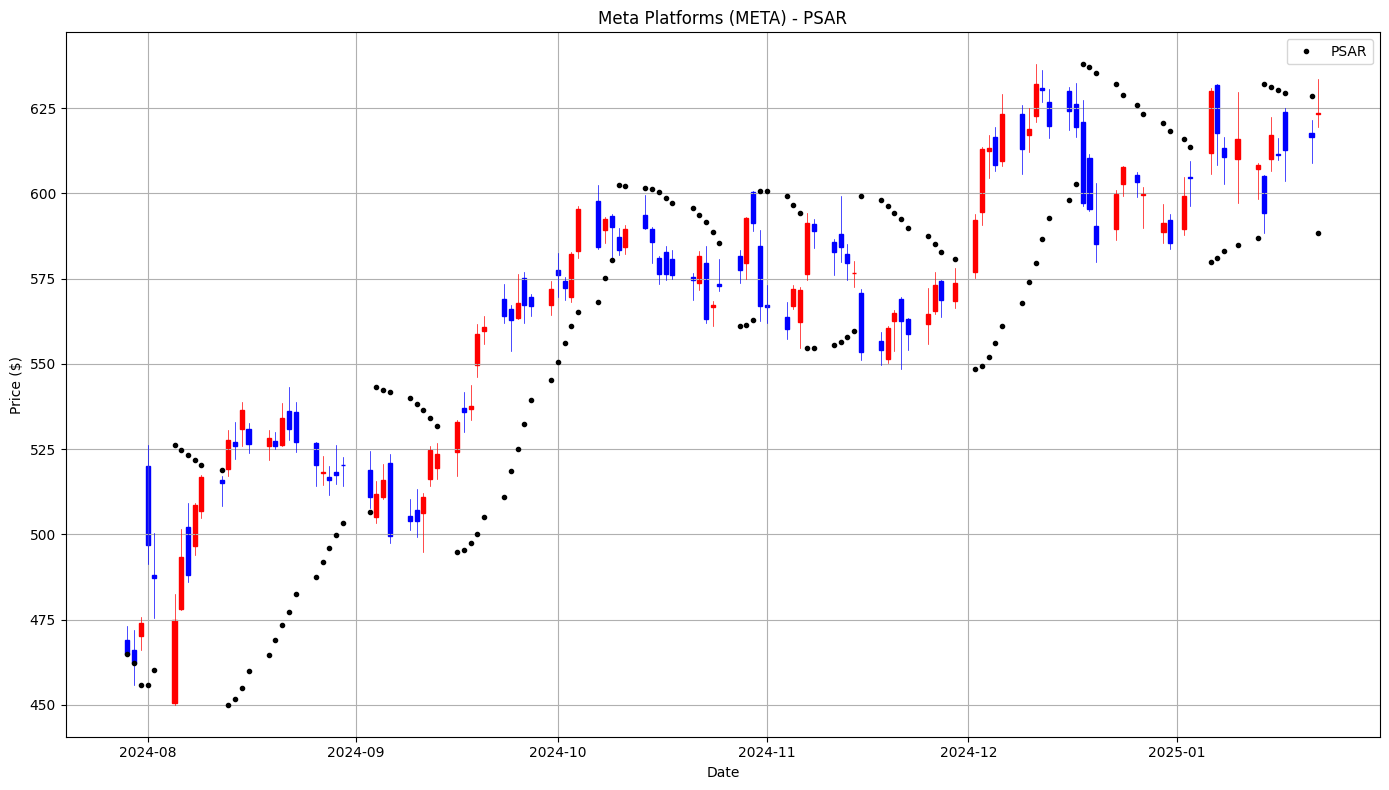

종목: NXPI (NXP Semiconductors), 현재가: $216.09


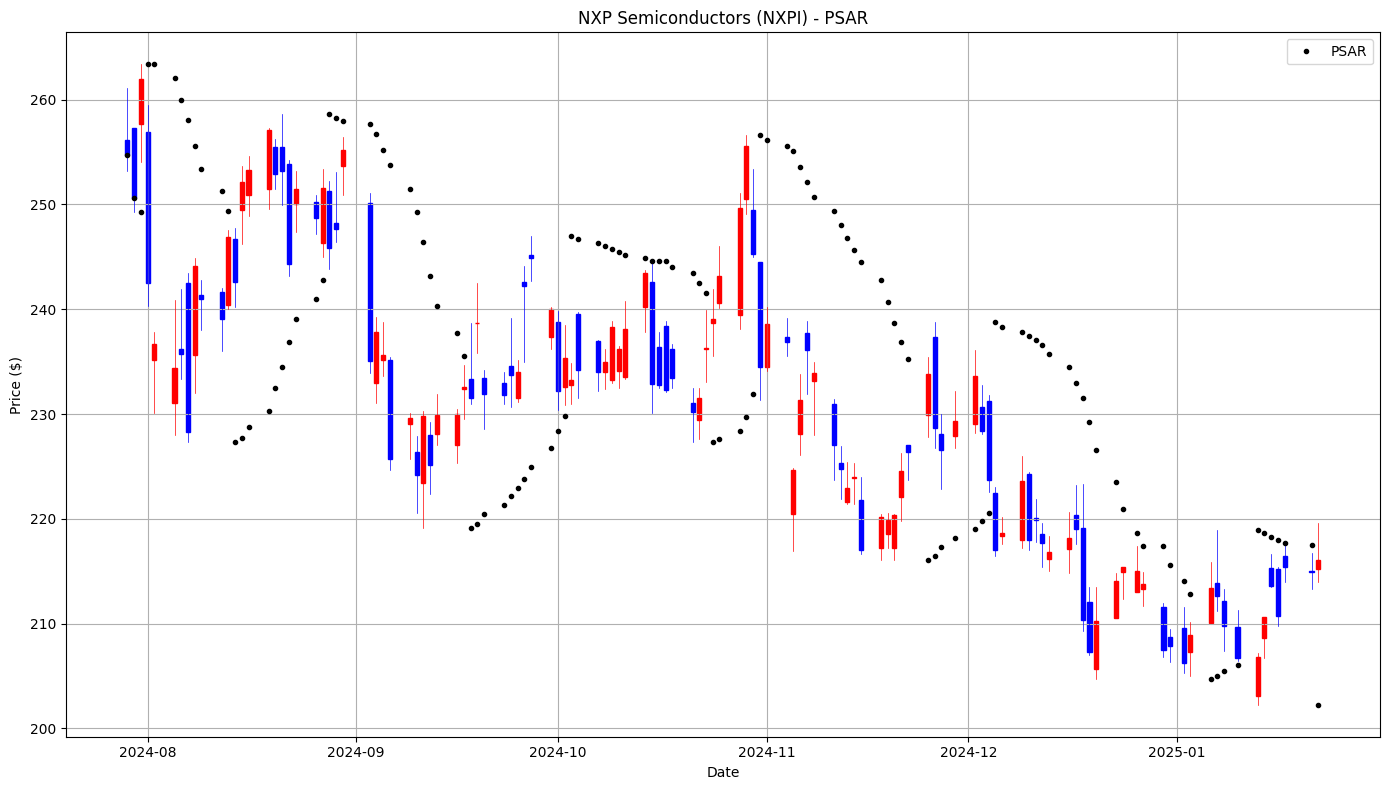

종목: PLTR (Palantir Technologies), 현재가: $76.87


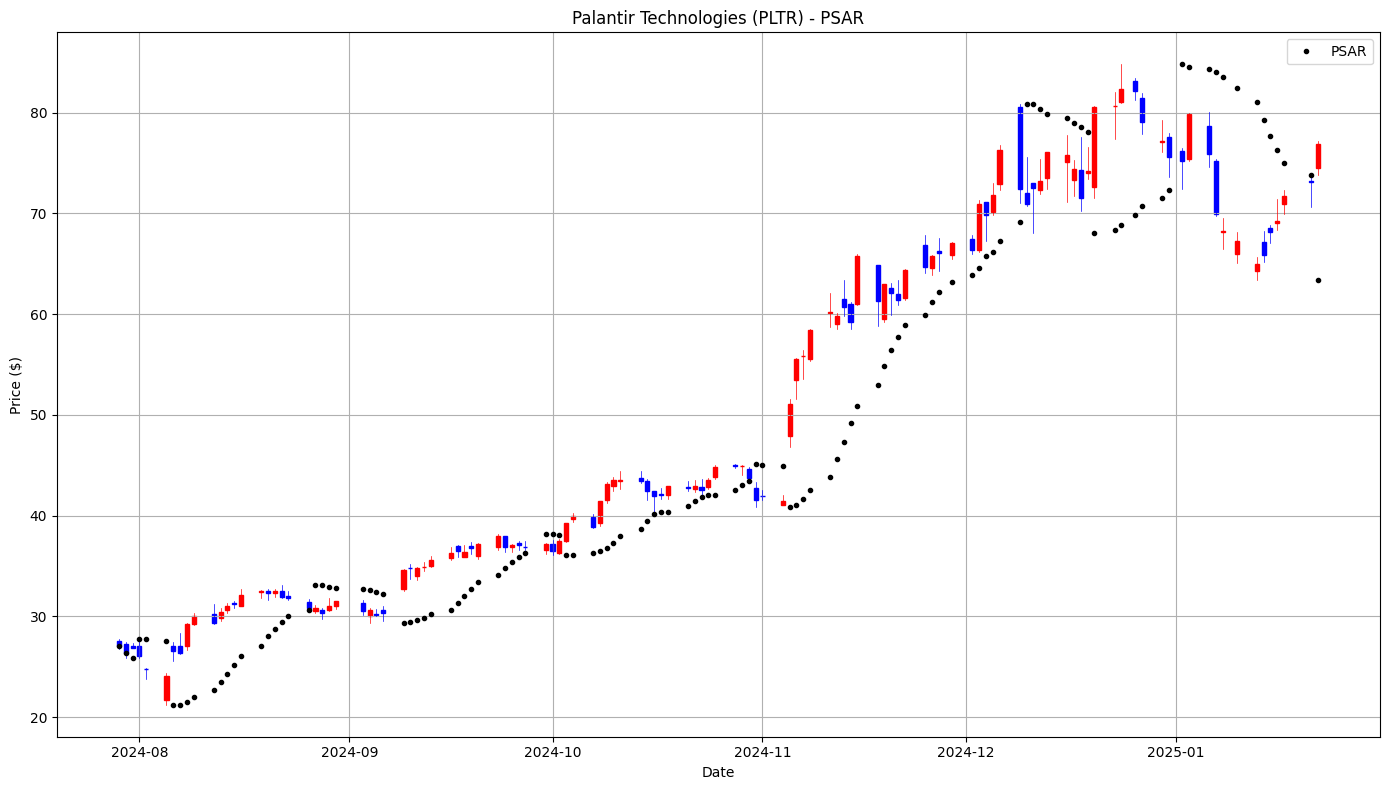

종목: TXN (Texas Instruments), 현재가: $197.05


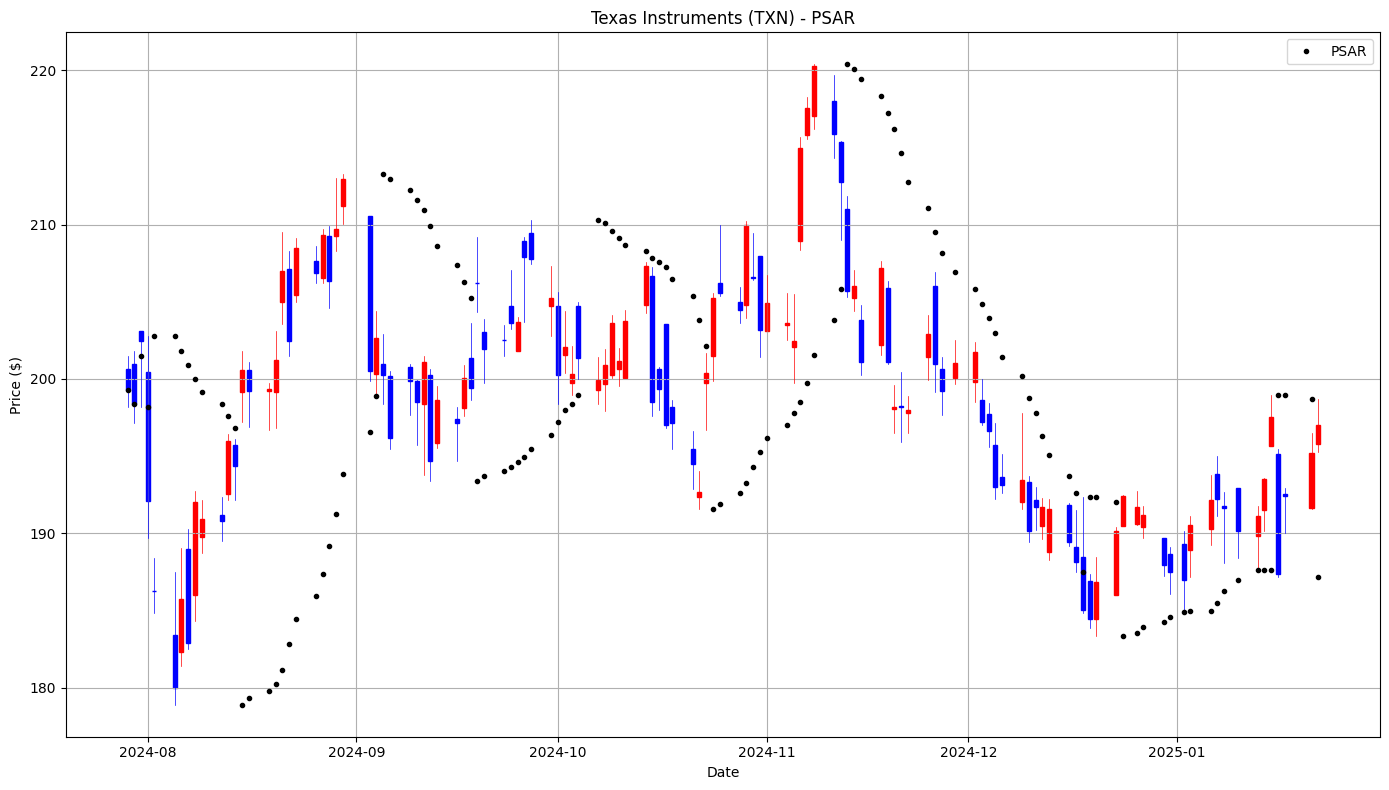

종목: WBD (Warner Bros. Discovery), 현재가: $10.05


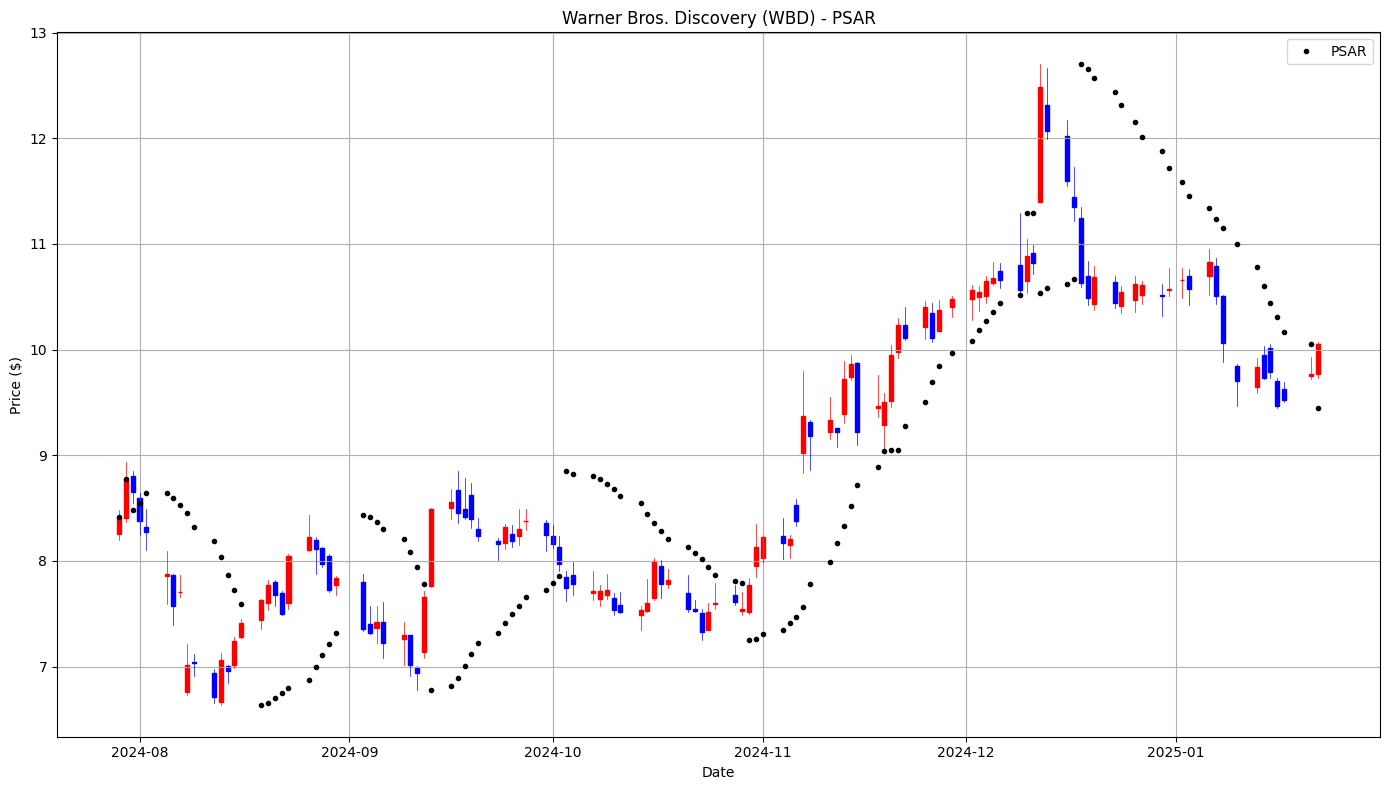

In [ ]:
# 나스닥100 종목대상 P-SAR 상승반전종목 리스트와 차트그리기 (25.01.23)
!pip install yfinance ta mplfinance

import pandas as pd
import yfinance as yf
from ta.trend import PSARIndicator
import datetime
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 1. 나스닥100 종목 리스트 가져오기 (Wikipedia 활용)
def get_nasdaq100_list():
    """Wikipedia에서 나스닥100 구성 종목 가져오기"""
    url = "https://en.wikipedia.org/wiki/NASDAQ-100"
    try:
        tables = pd.read_html(url)
        nasdaq100_table = tables[4]  # 나스닥100 종목 테이블
        #print("Selected Table Columns:", nasdaq100_table.columns)
        nasdaq100_dict = dict(zip(nasdaq100_table['Symbol'], nasdaq100_table['Company']))
        return nasdaq100_dict
    except Exception as e:
        print(f"Error fetching Nasdaq 100 list from Wikipedia: {e}")
        return {}

# 2. 실시간 주가 데이터 수집 (일봉)
def get_daily_price(ticker):
    """티커에 대한 일봉 데이터 가져오기"""
    today = datetime.datetime.today()
    start_date = (today - datetime.timedelta(days=180)).strftime("%Y-%m-%d")  # 최근 6개월 데이터
    end_date = today.strftime("%Y-%m-%d")

    try:
        df = yf.download(ticker, start=start_date, end=end_date, progress=False)
        if df.empty:
            print(f"{ticker}: 데이터를 가져올 수 없습니다.")
            return pd.DataFrame()

        # MultiIndex 처리: 단일 인덱스로 변환
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = [col[0] for col in df.columns]

        df = df.rename(columns={"Adj Close": "Adj_Close"})
        df.reset_index(inplace=True)
        df['Date'] = df['Date'].apply(mdates.date2num)  # 날짜를 숫자 포맷으로 변환 (캔들스틱용)
        return df
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return pd.DataFrame()

# 3. PSAR 계산
def calculate_psar(df):
    """PSAR 계산"""
    try:
        # 필요한 컬럼 확인
        required_columns = ['High', 'Low', 'Close']
        if not all(col in df.columns for col in required_columns):
            print(f"필수 컬럼이 누락되었습니다: {set(required_columns) - set(df.columns)}")
            return pd.DataFrame()

        # NaN 값 제거
        df = df.dropna(subset=required_columns)
        if df.empty:
            print("Error: No valid data after removing NaN values.")
            return pd.DataFrame()

        # PSAR 계산
        psar_indicator = PSARIndicator(high=df['High'], low=df['Low'], close=df['Close'])
        df['PSAR'] = psar_indicator.psar()
        return df
    except Exception as e:
        print(f"Error calculating PSAR: {e}")
        return pd.DataFrame()

# 4. PSAR 상승 전환 여부 확인
def is_psar_bullish_reversal(df):
    """PSAR 상승 전환 여부를 확인"""
    if len(df) < 2:
        return False
    prev_psar = df['PSAR'].iloc[-2]
    curr_psar = df['PSAR'].iloc[-1]
    prev_close = df['Close'].iloc[-2]
    curr_close = df['Close'].iloc[-1]
    return prev_close < prev_psar and curr_close > curr_psar

# 5. 조건 검색
def find_psar_signals():
    nasdaq100_dict = get_nasdaq100_list()
    results = []

    for ticker, name in nasdaq100_dict.items():
        try:
            #print(f"Processing {ticker} ({name})...")
            df = get_daily_price(ticker)
            if df.empty:
                continue

            # 데이터 컬럼 상태 확인
            #print(f"{ticker} 데이터 컬럼: {df.columns}")

            # PSAR 계산
            df = calculate_psar(df)
            if df.empty:
                print(f"{ticker}: PSAR 계산 실패")
                continue

            # PSAR 결과 확인
            #print(f"{ticker} PSAR 결과:\n", df[['High', 'Low', 'Close', 'PSAR']].tail())

            # PSAR 상승 전환 확인
            if is_psar_bullish_reversal(df):
                results.append({
                    "Ticker": ticker,
                    "Name": name,
                    "Price": df['Close'].iloc[-1],
                })
        except Exception as e:
            print(f"Error processing {ticker} ({name}): {e}")

    return results

# 6. 차트 시각화
def plot_chart(ticker, name, df):
    """종목의 차트를 시각화 (PSAR 포함)"""
    plt.figure(figsize=(14, 8))

    # 캔들스틱 차트
    ax = plt.gca()
    candlestick_ohlc(ax, df[['Date', 'Open', 'High', 'Low', 'Close']].values, width=0.6, colorup='red', colordown='blue')

    # PSAR 점 추가
    ax.plot(df['Date'], df['PSAR'], 'o', label="PSAR", markersize=3, color='black')

    # 제목 및 축 설정
    ax.xaxis_date()
    ax.set_title(f"{name} ({ticker}) - PSAR")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price ($)")
    ax.legend()
    ax.grid()

    plt.tight_layout()
    plt.show()

# 7. 메인 함수
def main():
    print("나스닥100 종목 PSAR 상승 전환 조건 검색 중...")
    signals = find_psar_signals()

    if signals:
        print(f"조건을 만족하는 종목 {len(signals)}개:")
        for signal in signals:
            ticker = signal["Ticker"]
            name = signal["Name"]
            price = "${:,.2f}".format(signal["Price"])
            print(f"종목: {ticker} ({name}), 현재가: {price}")

            df = get_daily_price(ticker)
            if df.empty:
                continue
            df = calculate_psar(df)
            plot_chart(ticker, name, df)
    else:
        print("조건을 만족하는 종목이 없습니다.")

if __name__ == "__main__":
    main()


